# Recursive forecasting example

In this notebook we will show how to use trend features in a recursive forecasting workflow where we also have features built from the target (e.g., lag & window features).

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")

# Data set synopsis

The air passengers dataset is the monthly totals of international airline passengers, from 1949 to 1960, in units of 1000s. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 5, in the folder "01-Create-Datasets" from this repo.

In [2]:
data = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

## Plot the data

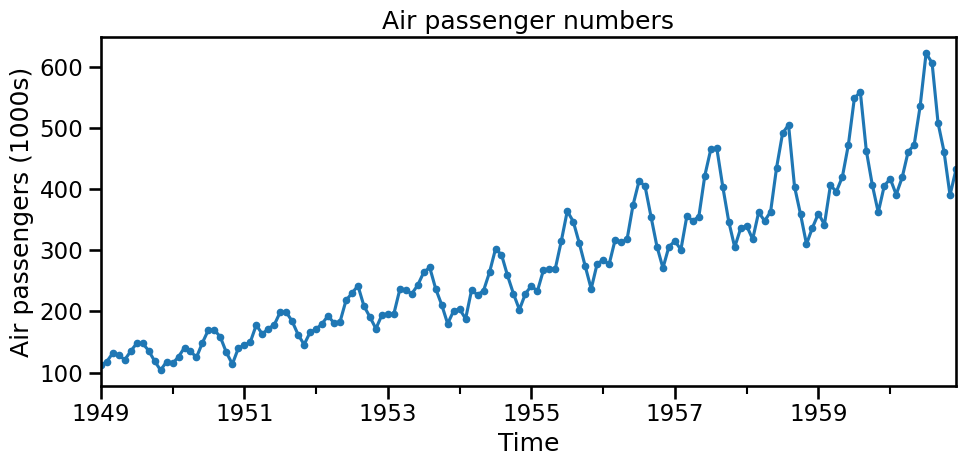

In [3]:
fig, ax = plt.subplots(figsize=[10, 5])
data.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Air passengers (1000s)")
ax.set_title("Air passenger numbers")
plt.tight_layout()

# Let's build some forecasts!

Let's build a recursive forecast and see how our trend feature can help!

In [4]:
# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

# set the outputs of sklearn to be pandas a df!
set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
                                       # for this feature

In [5]:
df = data.copy()
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Specify target name.

In [6]:
target = ["y"]  # Note: it's in a list.
# This ensures we'll get
# a dataframe when using df.loc[:, target]
# rather than a pandas Series.
# This can also be useful if we have
# multiple targets.

In [24]:
df.loc[:, target].head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Prepare our transformers.

In [7]:
## Polynomial time features
time_feats = make_pipeline(
    TimeSince(freq="MS"),
    PolynomialFeatures(degree=2, include_bias=False)
)


## lag & windows features
# Features computed from the target.
# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 2, 3, 12],  # Lag features.
        "mean": [[1, 12]],  # [[lag, window size]]
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

Create a pipeline to create all our features.

In [8]:
# Create features derived independent of one another
pipeline = make_union(time_feats, lag_window_feats)

# Apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [9]:
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince(freq='MS')),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1, 2, 3, 12], 'mean': [[1, 12]]},
                 target_cols=['y'], truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

Let's check how our feature engineering pipeline behaves.

In [10]:
pipeline.fit_transform(df)

,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2,y_lag_1,y_lag_2,y_lag_3,y_lag_12,y_mean_1_12
ds,,,,,,,
1949-01-01,0.000000,0.000000,0.015444,0.015444,0.015444,0.017582,0.000000
1949-02-01,0.006993,0.000049,0.015444,0.015444,0.015444,0.017582,0.000000
1949-03-01,0.013986,0.000196,0.027027,0.015444,0.015444,0.017582,0.000000
1949-04-01,0.020979,0.000440,0.054054,0.027027,0.015444,0.017582,0.000000
1949-05-01,0.027972,0.000782,0.048263,0.054054,0.027027,0.017582,0.000000
...,...,...,...,...,...,...,...
1960-08-01,0.972028,0.944838,1.000000,0.832046,0.710425,1.000000,0.958303
1960-09-01,0.979021,0.958482,0.969112,1.000000,0.832046,0.789011,0.969566
1960-10-01,0.986014,0.972224,0.779923,0.969112,1.000000,0.665934,0.980350


Let's reset our feature engineering pipeline.

In [11]:
# We can use `clone` to return an unfitted version
# of the pipeline.
pipeline = clone(pipeline)

Let's build a recursive forecast.

We'll start with configuring the forecast start time, the number of steps to forecast, and the forecasting horizon, and the model.

In [12]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

In [13]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split
forecast_start_time = pd.to_datetime("1955-10-01")

# Define number of steps to forecast.
num_of_forecast_steps = 36

# Define the model.
model = LinearRegression()

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(
    forecast_start_time, periods=num_of_forecast_steps, freq="MS"
)

# How much data in the past is needed to create our features ?
look_back_window_size = pd.DateOffset(months=12) # We need the latest 12 time periods
                                                 # in our predict dataframe to build our
                                                 # window features.

Let's create our training dataframe.

In [14]:
# --- CREATE TRAINING & TESTING DATAFRAME  --- #
# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

Let's compute our `X_train` and `y_train` and fit our model!

In [15]:
# --- FEATURE ENGINEERING--- #
# Create X_train and y_train
y_train = df_train[target]                 # target to predict
X_train = pipeline.fit_transform(df_train) # train features (after feature engeeniring)

# --- MODEL TRAINING --- #
# Train our one-step ahead forecast model
model.fit(X_train, y_train)

LinearRegression()

Let's prepare the dataframe that we will pass to `pipeline.transform()` to create `X_test` that we pass to `model.predict()`. This will contain some portion of time series during the training period so we can create any features that require historic data. Let's visualise the process that we are going to set up.

![](images/recursive_forecasting/Slide1.png)
![](images/recursive_forecasting/Slide2.png)
![](images/recursive_forecasting/Slide3.png)
![](images/recursive_forecasting/Slide4.png)

In [16]:
# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
# We will recursively append our forecasts to this
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
# `forecast_horizon` is a date range object the we specified few cells above. 
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

Let's recursively create `X_test` and make our predictions and append them to the `df_predict` dataframe.

In [17]:
# --- RECURSIVE FORECASTING LOOP --- #
"""
- `forecast_horizon` is a range of date (horizon) into the future
- 'forecast_time' loop over each single date (single step into the future)
"""
for forecast_time in forecast_horizon:
    ## Compute features during the forecast horizon
    # 1. take the data up to the date `forecast_time` 
    X_test = pipeline.transform(df_predict[:forecast_time])
    
    # 2. extract into var `X_test_` only the forcasting point! (the specific date)  
    X_test_ = X_test.loc[[forecast_time]]

    # 3. Predict one step ahead.
    y_pred = model.predict(X_test_)

    # 4. add the prediction to the target (`y`) where the date prediction is.
    # e.g, we predicted the date: 16.10.2023 and the prediction is - "123",
    # so we inseret the prediction "123" to the date. 
    
    # Append forecast to the target variable columnn in our
    # dynamic forecast dataframe `df_predict`. This `df_predict`
    # is ready for the next iteration where we will re-compute
    # features derived from the target such as lags and windows. 
    df_predict.loc[[forecast_time], target] = y_pred

Let's retrieve our forecast and actuals during the forecast horizon.

In [25]:
# --- GET FORECAST AND TEST VALUES --- #

# grap all the forecasts
y_forecast = df_predict.loc[forecast_horizon, target]
# grap the y test (the true) for comparisons 
y_test = df_test.loc[forecast_start_time:, target]

Let's create predictions on the training set using our one step ahead forecast model. This is useful to plot when debugging models.

In [19]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #

# make forecasting with the training data
y_forecast_train = model.predict(X_train)

# convert the predictions into a DataFrame object (for ploting)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

Let's plot the forecast!

Text(0.5, 1.0, 'Forecast with LinearRegression()')

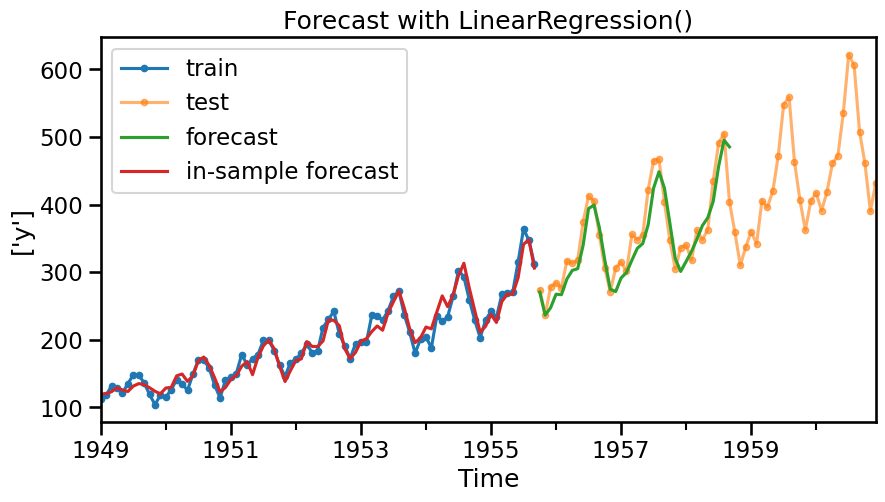

In [20]:
# --- PLOTTING --- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])

# Plot training set.
y_train.plot(ax=ax, marker=".")
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker=".", alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Forecast with {model}")

Let's look at the model coeffecients.

In [21]:
# Look at the most importent features
pd.Series(index=X_train.columns, data=model.coef_[0])

time_since_1949-01-01 00:00:00       29.946150
time_since_1949-01-01 00:00:00^2     10.248312
y_lag_1                             117.534675
y_lag_2                             -43.921994
y_lag_3                               5.653937
y_lag_12                            155.117821
y_mean_1_12                         -38.114138
dtype: float64

Let's compute the RMSE of this forecast.

In [22]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error

# let's see the differences between forecast values and the truth values
mean_squared_error(y_test.loc[y_forecast.index], y_forecast, squared=False)

26.56875300272188

We can now implement the time feature to capture trend alongside other features in a recursive forecasting workflow. We can see that the time feature can help capture the trend in the data when using linear models.

Feel free to change the dates, try different models, and different features!